In [1]:
import statistics
import time
import torch
import tqdm
import torch.utils.data as data
import torchvision.utils as tutils
import torchvision

from IPython.display import clear_output
from matplotlib import pyplot as plt
from statistics import mean
from torch import nn, optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
from PIL import Image

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

num_workers = 2
z_dim = 100
batch_size = 64
image_size = 64
num_epochs = 40
lr = 0.00005
clamp_lower = -0.01
clamp_upper = 0.01
n_critic = 5

cuda:0


# Generator
* same as DCGAN.

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Descriminator
* Difference between WGAN and DCGAN is activation function.
* In WGAN, last activation function sigmoid is removed.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Initialize weight.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(z_dim=100, image_size=64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Dataloader

In [6]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]
)

trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(len(trainloader)) # len returns iteration count per epoch.

938


torch.Size([64, 1, 64, 64])


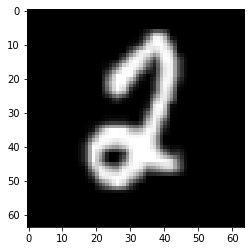

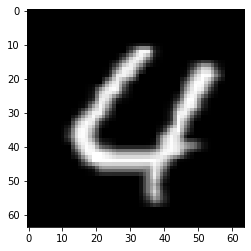

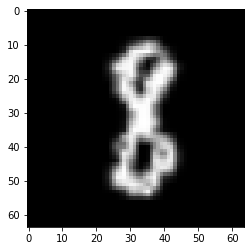

In [8]:
batch_iterator = iter(trainloader)
images, labels = next(batch_iterator)
print(images.size())

plt.imshow(images[0].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[1].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[2].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

# Optimizer
* use RMSProop.
* ADAM is not effective in WAGN.

In [9]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(D.parameters(), lr=lr)
optimizerG = optim.RMSprop(G.parameters(), lr=lr)

# Training
* D_loss measn Warenstein-distance.
* Warenstein-distance should be converge to 0.

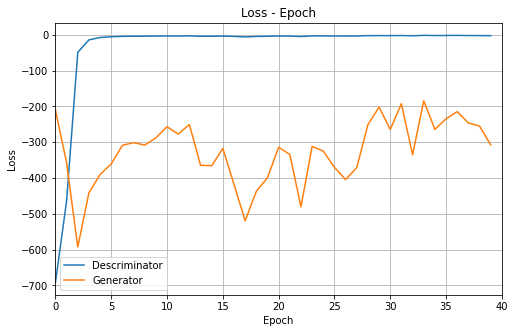

In [10]:
try:
    G_losses
except NameError:
    G_losses = list()
    D_losses = list()

D.to(device)
G.to(device)

for epoch in range(num_epochs):
    D.train()
    G.train()
    
    D_loss_list = list()
    G_loss_list = list()
    
    for i, (imgs, labels) in enumerate(trainloader):
        for n in range(n_critic):

            # Train D
            D.zero_grad()
            
            # Calculate real loss
            imgs = imgs.to(device)
            output = D(imgs).view(-1)
            D_real_loss = torch.mean(output)

            # Calculate fake loss
            batch_size =imgs.size(0)
            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake = G(noise)
            output = D(fake.detach()).view(-1)
            D_fake_loss = torch.mean(output)
            
            D_loss = - D_real_loss + D_fake_loss
            D_loss.backward()
            optimizerD.step()
            
            D_loss_list.append(D_loss.item())

            for p in D.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

        # Train G
        G.zero_grad()
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = G(noise)
        output = D(fake).view(-1)
        
        G_loss = - torch.mean(output)
        G_loss.backward()
        optimizerG.step()
        
        G_loss_list.append(G_loss.item())
        
        if i % 50 == 0:
            print(f"epoch: {epoch},  i: {i}, D_loss: {D_loss.item()},  G_loss: {G_loss.item()}")
        
    G_losses.append(statistics.mean(G_loss_list))
    D_losses.append(statistics.mean(D_loss_list))
        
    clear_output(wait=True)
    plt.figure(num=1, clear=True, figsize=(8, 5))
    plt.title('Loss - Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, len(G_losses))
    plt.plot(D_losses, label='Descriminator')
    plt.plot(G_losses, label='Generator')
    plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.pause(0.1)

# Visualize Result
* not so clear...

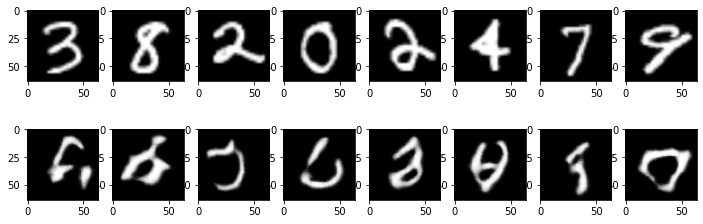

In [14]:
vis_batch_size = 8
z_dim = 100

fixed_z = torch.randn(vis_batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G.eval()
fake_images = G(fixed_z.to(device))

batch_iterator = iter(trainloader)
imges, _ = next(batch_iterator)

fig = plt.figure(figsize=(12, 4))
for i in range(0, 8):
    plt.subplot(2, 8, i+1)
        
    plt.imshow(imges[i].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
    
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')